In [95]:
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
%matplotlib inline

# Other Stuff
from scitime import Estimator
from datetime import datetime

matplotlib.pyplot:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Create Some Fake Time Series Data

In [3]:
t = np.arange(24*3600)
small_sin = np.sin(2*np.pi*t/30)     # 30 sec
med_cos = 3*np.cos(2*np.pi*t/300)    # 5 min
big_sin = 11*np.sin(2*np.pi*t/1200)  # 20 min
long_saw = 20*signal.sawtooth(2*np.pi*t/1800)  # 30 min
err = 0.75*np.random.randn(len(t))
sig = small_sin + med_cos + big_sin + long_saw + err

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


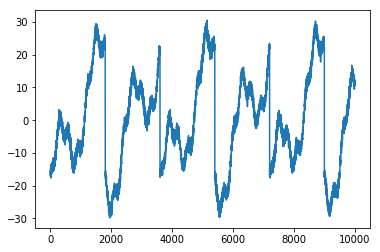

In [94]:
plt.plot(t[:10000],sig[:10000])

# Make Windows Function

In [4]:
from numpy.lib.stride_tricks import as_strided
def make_views(
  arr,
  win_size,
  step_size,
  writeable = False,
):
    """
    arr: any 2D array whose columns are distinct variables and 
    rows are data records at some timestamp t
    win_size: size of data window (given in data points along record/time axis)
    step_size: size of window step (given in data point along record/time axis)
    writable: if True, elements can be modified in new data structure, which will affect
    original array (defaults to False)
  
    Note that step_size is related to window overlap (overlap = win_size - step_size), in 
    case you think in overlaps.
  
    This function can work with C-like and F-like arrays, and with DataFrames.  Yay.
    """
  
    # If DataFrame, use only underlying NumPy array
    if type(arr) == type(pd.DataFrame()):
        arr = arr.values
  
    # Compute Shape Parameter for as_strided
    n_records = arr.shape[0]
    n_columns = arr.shape[1]
    remainder = (n_records - win_size) % step_size 
    num_windows = 1 + int((n_records - win_size - remainder) / step_size)
    shape = (num_windows, win_size, n_columns)
  
    # Compute Strides Parameter for as_strided
    next_win = step_size * arr.strides[0]
    next_row, next_col = arr.strides
    strides = (next_win, next_row, next_col)

    new_view_structure = as_strided(
      arr,
      shape = shape,
      strides = strides,
      writeable = writeable,
    )
    return new_view_structure

# 1800-Point Windows

In [5]:
# We will create 1801 windows, where first 1800 points are X and last point is y
data = make_views(sig.reshape(-1,1),1801,1)

In [6]:
x = data[:,:1800].squeeze()
y = data[:,1800].ravel()
print('Y shape:',y.shape,'\nX shape:',x.shape)

Y shape: (84600,) 
X shape: (84600, 1800)


## Estimate Computation Time

I ran a fairly default RF......and it took over an hour before I hit quit.  I saw on some blogs
that people start with very low mtry, e.g., 1 or 2, and build up from there if necessary.  

I also found a package that will estimate your sklearn runtime:
    https://stackoverflow.com/questions/22443041/predicting-how-long-an-scikit-learn-classification-will-take-to-run
    
So I downloaded that:
```
pip install scitime
```

Hmm... Now it's showing as if the computation time would only take 15-20 mins (?).

In [33]:
from scitime import Estimator
from datetime import datetime

In [29]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
estimator = Estimator() 
estimation, lower_bound, upper_bound = estimator.time(rf, x, y)

scitime.estimate.Estimator:DEBUG:The model would fit. Moving on
scitime.estimate.Estimator:DEBUG:Fetching estimator: RF_RandomForestRegressor_estimator.pkl
scitime.estimate.Estimator:INFO:Training your model for these params: {'total_memory': [17179869184], 'available_memory': [9180737536], 'num_cpu': [8], 'num_rows': [84600], 'num_features': [1800], 'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.0], 'max_features': ['auto'], 'criterion': ['mse'], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'bootstrap': [True], 'oob_score': [False], 'n_jobs': [8]}
scitime.estimate.Estimator:INFO:Transforming dataset for semi dummy features
scitime.estimate.Estimator:WARNING:Parameters ['warm_start', 'random_state', 'verbose'] will not be accounted for
scitime.estimate.Estimator:INFO:Training your RandomForestRegressor model should take ~ 5 minutes
                and 52 seconds
sci

In [30]:
print(f'Lower Bound: {round(lower_bound/60,1)} mins')
print(f'Estimation: {round(estimation/60,1)} mins')
print(f'Upper Bound: {round(upper_bound/60,1)} mins')

Lower Bound: 0.0 mins
Estimation: 5.9 mins
Upper Bound: 16.1 mins


# Create Random Forest 
First, we look at 1800-point windows, where we try to predict the next point.  In other words,
assuming we could make a prediction in a millisecond, we have the most recent data point (current
moment) and 1799 look-back data points, and we want to predict the next second.  

I saw somewhere that using `max_features=2` is a good way to speed up computation time
for a large feature set.  Considering that we are currently using 1800-point windows, I'd 
say this fits the bill.

Note that the trn/val splits must be done on the original
time series before any windowing is done.  At least, this is an easy way to avoid direct leakage.

In [188]:
def trn_val_data(
    signal, 
    win_size, 
    trn_sz=0.7,
):

    trn = round(len(signal)*trn_sz)

    sig_trn = signal[:trn]
    data_trn = make_views(sig_trn.reshape(-1,1) ,win_size+1, 1)
    x_trn = data_trn[:, :win_size].squeeze()
    y_trn = data_trn[:, win_size].ravel()
    
    sig_val = signal[trn:]
    data_val = make_views(sig_val.reshape(-1,1), win_size+1, 1)
    x_val = data_val[:, :win_size].squeeze()
    y_val = data_val[:, win_size].ravel()

    print('X trn shape:', x_trn.shape, '\nY trn shape:', y_trn.shape)
    
    return x_trn, y_trn, x_val, y_val

In [84]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)

In [152]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 1800)

X trn shape: (58680, 1800) 
Y trn shape: (58680,)


In [99]:
estimator = Estimator() 
estimation, lower_bound, upper_bound = estimator.time(rf, x_trn, y_trn)

scitime.estimate.Estimator:DEBUG:The model would fit. Moving on
scitime.estimate.Estimator:DEBUG:Fetching estimator: RF_RandomForestRegressor_estimator.pkl
scitime.estimate.Estimator:INFO:Training your model for these params: {'total_memory': [17179869184], 'available_memory': [7110299648], 'num_cpu': [8], 'num_rows': [58680], 'num_features': [1800], 'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.0], 'max_features': [2], 'criterion': ['mse'], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'bootstrap': [True], 'oob_score': [False], 'n_jobs': [8]}
scitime.estimate.Estimator:INFO:Transforming dataset for semi dummy features
scitime.estimate.Estimator:WARNING:Parameters ['warm_start', 'random_state', 'verbose'] will not be accounted for
scitime.estimate.Estimator:INFO:Training your RandomForestRegressor model should take ~ 4 minutes
                and 5 seconds
scitime.e

In [100]:
print(f'Lower Bound: {round(lower_bound/60,1)} mins')
print(f'Estimation: {round(estimation/60,1)} mins')
print(f'Upper Bound: {round(upper_bound/60,1)} mins')

Lower Bound: 0.0 mins
Estimation: 4.1 mins
Upper Bound: 13.6 mins


In [153]:
t0 = datetime.now()
rf.fit(x_trn, y_trn)
tf = datetime.now()

In [154]:
print('Computation Time:', (tf-t0))

Computation Time: 0:00:03.371777


In [155]:
p = rf.predict(x_val)

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


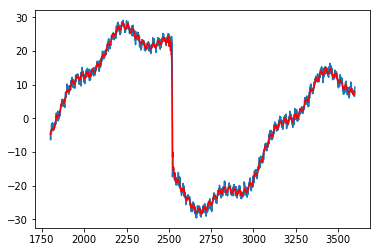

In [156]:
plt.plot(t[1800:3600],y_val[:1800])
plt.plot(t[1800:3600],p[:1800],'red')

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


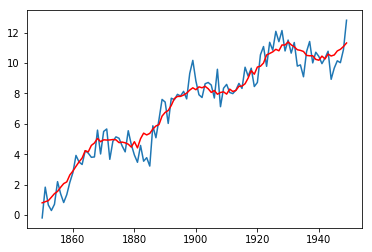

In [157]:
plt.plot(t[1850:1950],y_val[50:150])
plt.plot(t[1850:1950],p[50:150],'red')

from sklearn.metrics import r2_score

In [108]:
r2_score(y_val, p)

0.9939148325356025

Another thing I was thinking when my model was running forever was, "I wish I knew what
was happening?  Like, what tree is it on?!"  I found out that you can see this type of info
if you set `verbose=3`.  

I found that if you set this verbosity level, then look at the scitime computation time estimate,
then it somehow resets the verbosity to the default level.  So if you want to look at a verbose
RF creation, you cannot first run the RF through a scitime estimate...

Wow...

What if we change max_features to 1, like I've seen elsewhere...

In [57]:
rf2 = RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=-1, max_features=1)

In [109]:
rf2.fit(x_trn, y_trn)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

In [110]:
p2 = rf2.predict(x_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [111]:
r2_score(y_val, p2)

0.9934215421160087

# Fewer Inputs:  900-point window (15 minutes)
So we knew that the largest repetition was 30 minutes...but what if we didn't?

What if we only used 15 minutes of inputs?

In [223]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 900)

X trn shape: (59580, 900) 
Y trn shape: (59580,)


In [224]:
rf3 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf3.fit(x_trn, y_trn)
p3 = rf3.predict(x_val)

In [225]:
r2_score(y_val, p3)

0.9938220246804234

# Even Fewer Inputs: 300-point window (5 minutes)
Ok, wow... so 15 minutes still gets 99.91% r2 score.  Same basic score as using 30 minutes of input.

How about if we use 5 minutes?

In [226]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 300)

X trn shape: (60180, 300) 
Y trn shape: (60180,)


In [227]:
rf4 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf4.fit(x_trn, y_trn)
p4 = rf4.predict(x_val)

In [228]:
r2_score(y_val, p4)

0.9932381603168574

Ok, so using just 5 minutes of data input, we can have 99.906%, where as it is
99.914% with 30 minutes....

How about 1 minute?

# Very Few: 60-point window (1 minute)

In [229]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 60)

X trn shape: (60420, 60) 
Y trn shape: (60420,)


In [230]:
rf5 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf5.fit(x_trn, y_trn)
p5 = rf5.predict(x_val)

In [231]:
r2_score(y_val, p5)

0.9914152649572248

Ok, wow... So we still get 99.88% accuracy with just one minute of data.

In [232]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 30)

X trn shape: (60450, 30) 
Y trn shape: (60450,)


In [233]:
rf30 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf30.fit(x_trn, y_trn)
p30 = rf30.predict(x_val)

In [234]:
r2_score(y_val, p30)

0.9911714359151447

# WTF?  Still good?  

In [235]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 10)

X trn shape: (60470, 10) 
Y trn shape: (60470,)


In [236]:
rf10 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf10.fit(x_trn, y_trn)
p10 = rf10.predict(x_val)
r2_score(y_val, p10)

0.9914969866733099

# Uhhhh

In [237]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 3)

X trn shape: (60477, 3) 
Y trn shape: (60477,)


In [238]:
rf3 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf3.fit(x_trn, y_trn)
p3 = rf3.predict(x_val)
r2_score(y_val, p3)

0.9907293357814343

# Uhhhh.  Uhhhhh.  2?

In [239]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, 2)

X trn shape: (60478, 2) 
Y trn shape: (60478,)


In [240]:
rf2 = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf2.fit(x_trn, y_trn)
p2 = rf2.predict(x_val)
r2_score(y_val, p2)

0.9896344075784369

### Some Thoughts

These results seem too good to be true.  I still get 99% r2 score (or 98.96%, if you're an asshole).  Like,
wow...  Wtf?  

A few things contribute to this optimism.

1. For one, the purely periodic signal I created is slowly varying relative to the 1 Hz sample rate.  If 
you recall, I have 3 sinusoids oscillating at 30s, 5m, and 20m, then a sawtooth at 30m.  Other than 
the 30s wave, 3-dp windows (x1,x2,y) are fairly constant.  My guess is that the trees just learn to output 
the same round about number as was entered... More specifically, I'd wager it basically takes an average
of the last several data points...which the figures I first plotted at the way beginning show.  My
guess is I can get the same roundabout accuracy by explicitly average the last several data points to
make a prediction. 
I found a [blog](http://astrohackweek.org/blog/time-series-rf.html) that did a very similar analysis, 
but w/ light curve data from a star.  Same great results.  Looking at the data, seems like the
optimism arises b/c of very similar reasoning.  


2. Who needs to know what is going to happen a second from now anyway?  A more realistic
prediction might be:  What will happen 10 minutes from now?
This makes for some interesting (complicated) windowing/slicing.  Also, defining the target is
not straightforward here either (which would decrease optimism): given we have 1 Hz data and 10
minutes into the future is 1-2 orders of magnitude larger than this sampling rate, a question arises around
the specificity of such a prediction: do we want to predict the value of
a second that will be recorded *exactly* 10 minutes from now, or a less noisy 10-30 second avg 10mins 
from now...?


3. Notice that in my quickness to check things out, I've created a purely periodic signal, 
such that the output range in val/test never exceeds the output range
seen in training.  This gives a *VERY* optimistic outlook on how random forests can
generally handle time series data.  We should be much more pessimistic: training on historical data will limit 
the RF to making predictions within the historical target range.  If we are looking at a business' 
customer growth over time, this won't work at all!  (For more info: https://medium.com/datadriveninvestor/why-wont-time-series-data-and-random-forests-work-very-well-together-3c9f7b271631)


Below, I show how pessimistic we should be by addressing some of these points, e.g., by adding a linear trend
to the purely periodic signal we've been using.  One might speculate there is a remedy -- likely in
a preprocessing step.  For example, one might assume the growth is quasi-linear, and so fit
a linear regression first and subtract it from the data, then use the residuals as inputs to 
the RF.  To avoid target leakage and/or overfitting to the training set here, one might use 50% of
training to do the linear fit, the then other 50% of training (residuals) to do the RF fit.

Another possibility to deal with trends: to predict x[t+1], do the following:
* subtract x[t] from everything
* use x[t-1] - x[t], x[t-1] - x[t], etc, to predict x[t+1] - x[t]
* add x[t] back to the prediction


# Predicting 10 Minutes From Now

In [189]:
def trn_val_data(
    signal, 
    win_size, 
    prediction_point = 1,
    trn_sz=0.7,
):

    split_point = round(len(signal)*trn_sz)

    sig_trn = signal[:split_point]
    data_trn = make_views(sig_trn.reshape(-1,1) ,win_size + prediction_point, 1)
    x_trn = data_trn[:, :win_size].squeeze()
    y_trn = data_trn[:, win_size + prediction_point - 1].ravel()
    
    sig_val = signal[split_point:]
    data_val = make_views(sig_val.reshape(-1,1), win_size + prediction_point, 1)
    x_val = data_val[:, :win_size].squeeze()
    y_val = data_val[:, win_size  + prediction_point - 1].ravel()

    print('X trn shape:', x_trn.shape, '\nY trn shape:', y_trn.shape)
    
    return x_trn, y_trn, x_val, y_val

## Starting with 2-second window

In [241]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, win_size=2, prediction_point=60*10)

X trn shape: (59879, 2) 
Y trn shape: (59879,)


In [242]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn, y_trn)
p = rf.predict(x_val)
r2_score(y_val, p)

0.35234514136723116

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


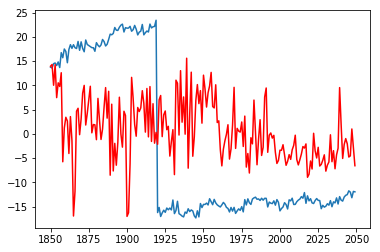

In [192]:
plt.plot(t[1850:2050], y_val[50:250])
plt.plot(t[1850:2050], p[50:250],'red')

Great!  It was horrible as one would expect.

Let's try larger windows.

## 60-point window (1 minute)

In [193]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, win_size=60, prediction_point=60*10)

X trn shape: (59821, 60) 
Y trn shape: (59821,)


In [194]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn, y_trn)
p = rf.predict(x_val)
r2_score(y_val, p)

0.8498494677813561

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


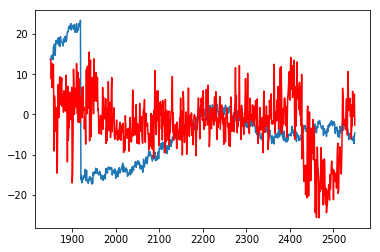

In [244]:
plt.plot(t[1850:2550], y_val[50:750])
plt.plot(t[1850:2550], p[50:750],'red')

# 300-point window (5 minutes)

In [245]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig, win_size=300, prediction_point=60*10)

X trn shape: (59581, 300) 
Y trn shape: (59581,)


In [246]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn, y_trn)
p = rf.predict(x_val)
r2_score(y_val, p)

0.992228343839094

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


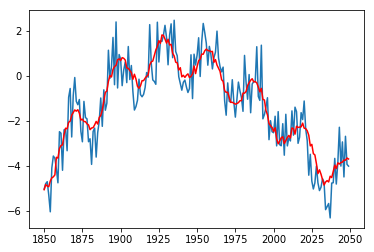

In [247]:
plt.plot(t[1850:2050], y_val[50:250])
plt.plot(t[1850:2050], p[50:250],'red')

# Predictions w/ a Linear Trend in the Time Series
## 1. Naive Attempt

In [199]:
sig2 = sig + t/500

In [200]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig2, win_size=300, prediction_point=1)

X trn shape: (60180, 300) 
Y trn shape: (60180,)


matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


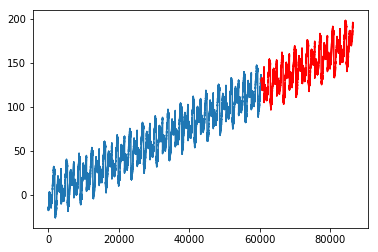

In [201]:
split_point = round(0.7*len(sig2))
plt.plot(t[:split_point], sig2[:split_point])
plt.plot(t[split_point:], sig2[split_point:], 'red')

In [202]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn, y_trn)
p = rf.predict(x_val)
r2_score(y_val, p)

-0.05910475676118554

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


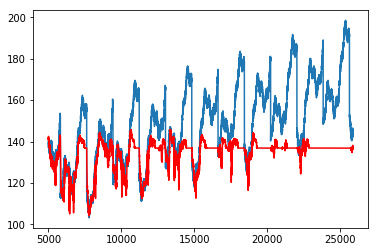

In [222]:
plt.plot(t[5000:25850], y_val[3200:24050])
plt.plot(t[5000:25850], p[3200:24050],'red')

## 2. Potentially Less Naive Attempt
### 5-Minute Window

In [269]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig2, win_size=300, prediction_point=1)

x_trn_mod = x_trn - x_trn[:,-1:]
y_trn_mod = y_trn - x_trn[:,-1]

x_val_mod = x_val - x_val[:,-1:]
y_val_mod = y_val - x_val[:,-1]

In [270]:
print('Trn:', np.min(x_trn_mod), np.median(x_trn_mod), np.max(x_trn_mod))
print('Val:', np.min(x_val_mod), np.median(x_val_mod), np.max(x_val_mod))

Trn: -26.789156354650117 -1.352393925946294 56.27509991801519
Val: -26.88226943496423 -1.4406167996634194 56.04825558066757


In [271]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn_mod, y_trn_mod)
p = rf.predict(x_val_mod)
r2_score(y_val_mod, p)

0.4707841222481486

### 10-Minute Window

In [272]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig2, win_size=600, prediction_point=1)

x_trn_mod = x_trn - x_trn[:,-1:]
y_trn_mod = y_trn - x_trn[:,-1]

x_val_mod = x_val - x_val[:,-1:]
y_val_mod = y_val - x_val[:,-1]

X trn shape: (59880, 600) 
Y trn shape: (59880,)


In [273]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn_mod, y_trn_mod)
p = rf.predict(x_val_mod)
r2_score(y_val_mod, p)

0.2641952186791422

### 1-Minute Window

In [274]:
x_trn, y_trn, x_val, y_val = trn_val_data(sig2, win_size=60, prediction_point=1)

x_trn_mod = x_trn - x_trn[:,-1:]
y_trn_mod = y_trn - x_trn[:,-1]

x_val_mod = x_val - x_val[:,-1:]
y_val_mod = y_val - x_val[:,-1]

X trn shape: (60420, 60) 
Y trn shape: (60420,)


In [275]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, n_jobs=-1)
rf.fit(x_trn_mod, y_trn_mod)
p = rf.predict(x_val_mod)
r2_score(y_val_mod, p)

0.20348418940961044

Hmmmm... This differncing style doesn't seem to work... Maybe we should just difference the
time series before windowing.  Make the prediction on a difference....